In [1]:
import numpy as np
import gensim.downloader as api
from sklearn.decomposition import PCA
from scipy.stats import spearmanr
import os
from gensim.models import KeyedVectors
from sklearn.metrics import mean_squared_error
from cuml.manifold import UMAP
import csv
import pandas as pd

In [2]:
class ReducedEmbeddingModel:
    def __init__(self, vectors, index_to_key):
        self.vectors = vectors
        self.index_to_key = index_to_key
        self.key_to_index = {word: idx for idx, word in enumerate(index_to_key)}
    
    def __getitem__(self, word):
        if word in self.key_to_index:
            return self.vectors[self.key_to_index[word]]
        raise KeyError(f"Word '{word}' not found in vocabulary")
    
    def __contains__(self, word):
        return word in self.key_to_index

def load_glove_model(file_path):
    """Loads GloVe embeddings from a text file."""
    index_to_key = []
    vectors = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.split()
            word = parts[0]
            vector = np.array(parts[1:], dtype=np.float32)
            index_to_key.append(word)
            vectors.append(vector)
    vectors = np.vstack(vectors)
    return ReducedEmbeddingModel(vectors, index_to_key)

def load_similarity_dataset(file_path):

  data = []
  with open(file_path, 'r') as file:
        next(file)  # Skip header
        for line in file:
            parts = line.strip().split('\t')
            word1, word2, similarity_score = parts[0], parts[1], float(parts[3])
            data.append((word1, word2, similarity_score))
  return data

# Cosine similarity function for similarity evaluation
def cosine_similarity(v1, v2):
    norm1 = np.linalg.norm(v1)
    norm2 = np.linalg.norm(v2)
    if norm1 == 0 or norm2 == 0:
        return 0
    return np.dot(v1, v2) / (norm1 * norm2)

# Evaluate embeddings on the SimLex-999 data
def evaluate_embeddings(model, word_pairs):
    predicted_scores = []
    true_scores = []
    
    for word1, word2, true_score in word_pairs:
        if word1 in model and word2 in model:
            sim_score = cosine_similarity(model[word1], model[word2])
            predicted_scores.append(sim_score)
            true_scores.append(true_score)
    
    # Calculate Spearman correlation for word similarity performance
    correlation, _ = spearmanr(true_scores, predicted_scores)
    return correlation

In [3]:
def task_driven_dimensionality_reduction_umap(embeddings, word_pairs, model, target_dim=3, n_neighbors=15, min_dist=0.1):
    """
    Perform task-driven dimensionality reduction using UMAP.
    """
    # Initialize UMAP for dimensionality reduction
    umap_reducer = UMAP(n_components=target_dim, n_neighbors=15, min_dist=min_dist, metric='cosine')
    reduced_embeddings = umap_reducer.fit_transform(embeddings)
    
    # Create a reduced model
    optimized_model = {word: reduced_embeddings[i] for i, word in enumerate(model.index_to_key)}
    
    # Evaluate the reduction
    correlation = evaluate_embeddings(optimized_model, word_pairs)
    print(f"Spearman Correlation with UMAP (n_neighbors={15}, min_dist={min_dist}): {correlation:.4f}")
    
    return reduced_embeddings, correlation


In [4]:
glove_file_path = '/teamspace/uploads/glove.6B.300d.txt'  
simlex_file_path = '/teamspace/studios/pca/SimLex-999.txt'   
target_dim = 2  


In [5]:
print("Loading GloVe model...")
original_model = load_glove_model(glove_file_path)



Loading GloVe model...


In [6]:
word_pairs = load_similarity_dataset(simlex_file_path)

In [7]:
# Initialize a list to store correlations for each min_dist value
correlations = []

# UMAP Dimensionality Reduction Loop
min_dist_values = [round(i * 0.1, 1) for i in range(6, 11)]  
n_neighbors = 15
best_correlation = -1
best_params = {}
optimized_embeddings1 = None

print("UMAP Dimensionality Reduction Results:")
for min_dist in min_dist_values:
    # Apply UMAP with the current min_dist and fixed n_neighbors
    current_embeddings, current_correlation = task_driven_dimensionality_reduction_umap(
        original_model.vectors, 
        word_pairs=word_pairs, 
        model=original_model,
        target_dim=target_dim,
        min_dist=min_dist,
        n_neighbors=n_neighbors
    )
    
    # Print and track results
    print(f"Spearman Correlation at min_dist={min_dist:.1f}: {current_correlation:.4f}")
    correlations.append(current_correlation)  # Store correlation for each min_dist
    if current_correlation > best_correlation:
        best_correlation = current_correlation
        best_params = {"min_dist": min_dist, "n_neighbors": n_neighbors}
        optimized_embeddings1 = current_embeddings

# Final results
print(f"\nFinal Optimized Spearman Correlation at {target_dim}D: {best_correlation:.4f}")
print(f"Optimal UMAP Parameters: {best_params}")

# Save the 2D embeddings with word labels to a CSV file
def save_embeddings_to_csv(words, embeddings, file_path):
    print(f"Saving 2D embeddings to {file_path}...")
    df = pd.DataFrame(embeddings, columns=['x', 'y'])
    df['word'] = words
    df.to_csv(file_path, index=False)
    print("2D embeddings saved successfully.")

# Get words and their high-dimensional embeddings
words = original_model.index_to_key  # List of words in vocabulary
############# CHANGE NAME BY ADDING RESULT VALUE
file_path="TestGlove_UMAP_2d_word_embeddings_1234.csv"
# Save the embeddings and words to a CSV file
############# REPLACE optimized_embeddings WITH THE BEST ONE!
save_embeddings_to_csv(words, optimized_embeddings1, file_path)

# # Save UMAP results to a text file
# results_file_path = "umap_results.txt"

# with open(results_file_path, "w") as file:
    
#     for min_dist, correlation in zip(min_dist_values, correlations):  # Use the correlations list here
#         file.write(f"min_dist={min_dist:.1f}, Spearman Correlation={correlation:.4f}\n")
    
# print(f"Results saved to {results_file_path}")


UMAP Dimensionality Reduction Results:


Spearman Correlation with UMAP (n_neighbors=15, min_dist=0.6): 0.2052
Spearman Correlation at min_dist=0.6: 0.2052
Spearman Correlation with UMAP (n_neighbors=15, min_dist=0.7): 0.1739
Spearman Correlation at min_dist=0.7: 0.1739


KeyboardInterrupt: 

In [11]:
import pandas as pd
import numpy as np
from scipy.stats import spearmanr
from sklearn.metrics.pairwise import cosine_similarity

# Load SimLex-999 data
def load_simlex_999(filepath):
    """Loads the SimLex-999 dataset."""
    word_pairs = []
    with open(filepath, 'r') as f:
        next(f)  # Skip the header line
        for line in f:
            parts = line.strip().split('\t')
            word1, word2, simlex_score = parts[0], parts[1], float(parts[3])
            word_pairs.append((word1, word2, simlex_score))
    return word_pairs

# Evaluate embeddings on the SimLex-999 data
def evaluate_embeddings(model, word_pairs):
    """Evaluates embeddings using SimLex-999 data and Spearman correlation."""
    predicted_scores = []
    true_scores = []

    for word1, word2, true_score in word_pairs:
        if word1 in model and word2 in model:
            sim_score = cosine_similarity(model[word1].reshape(1, -1), model[word2].reshape(1, -1))[0][0]
            predicted_scores.append(sim_score)
            true_scores.append(true_score)

    # Calculate Spearman correlation for word similarity performance
    correlation, _ = spearmanr(true_scores, predicted_scores)
    return correlation

# Path to your CSV file containing embeddings
embeddings_csv_path = '/teamspace/studios/this_studio/Word2Vec_UMAP_2d_word_embeddings_1234.csv'  # Update this with your actual file path

# Load embeddings from CSV
def load_embeddings_from_csv(filepath):
    """Loads word embeddings from a CSV file into a dictionary."""
    df = pd.read_csv(filepath)
    model = {}
    for index, row in df.iterrows():
        word = row['word']
        embedding = np.array([row['x'], row['y']], dtype=np.float32)
        model[word] = embedding
    return model

# Load the embeddings
model = load_embeddings_from_csv(embeddings_csv_path)

# Load SimLex-999 word pairs
simlex_file_path = '/teamspace/studios/pca/SimLex-999.txt'  # Update this path to your SimLex-999 file
word_pairs = load_simlex_999(simlex_file_path)

# Evaluate the embeddings
correlation = evaluate_embeddings(model, word_pairs)
print(f"Spearman correlation on SimLex-999: {correlation}")

Spearman correlation on SimLex-999: 0.19340447882389764


In [7]:
# Initialize a list to store correlations for each min_dist value
correlations = []

# UMAP Dimensionality Reduction Loop
min_dist_values = [round(i * 0.1, 1) for i in range(1, 11)]  
n_neighbors = 15
best_correlation = -1
best_params = {}
optimized_embeddings1 = None

print("UMAP Dimensionality Reduction Results:")
for min_dist in min_dist_values:
    # Apply UMAP with the current min_dist and fixed n_neighbors
    current_embeddings, current_correlation = task_driven_dimensionality_reduction_umap(
        original_model.vectors, 
        word_pairs=word_pairs, 
        model=original_model,
        target_dim=target_dim,
        min_dist=min_dist,
        n_neighbors=n_neighbors
    )
    
    # Print and track results
    print(f"Spearman Correlation at min_dist={min_dist:.1f}: {current_correlation:.4f}")
    correlations.append(current_correlation)  # Store correlation for each min_dist
    if current_correlation > best_correlation:
        best_correlation = current_correlation
        best_params = {"min_dist": min_dist, "n_neighbors": n_neighbors}
        optimized_embeddings1 = current_embeddings

# Final results
print(f"\nFinal Optimized Spearman Correlation at {target_dim}D: {best_correlation:.4f}")
print(f"Optimal UMAP Parameters: {best_params}")

# Save UMAP results to a text file
results_file_path = "umap_results.txt"

with open(results_file_path, "w") as file:
    
    for min_dist, correlation in zip(min_dist_values, correlations):  # Use the correlations list here
        file.write(f"min_dist={min_dist:.1f}, Spearman Correlation={correlation:.4f}\n")
    
print(f"Results saved to {results_file_path}")


UMAP Dimensionality Reduction Results:


Spearman Correlation with UMAP (n_neighbors=15, min_dist=0.1): 0.2172
Spearman Correlation at min_dist=0.1: 0.2172
Spearman Correlation with UMAP (n_neighbors=15, min_dist=0.2): 0.2012
Spearman Correlation at min_dist=0.2: 0.2012
Spearman Correlation with UMAP (n_neighbors=15, min_dist=0.3): 0.2333
Spearman Correlation at min_dist=0.3: 0.2333
Spearman Correlation with UMAP (n_neighbors=15, min_dist=0.4): 0.1664
Spearman Correlation at min_dist=0.4: 0.1664
Spearman Correlation with UMAP (n_neighbors=15, min_dist=0.5): 0.1905
Spearman Correlation at min_dist=0.5: 0.1905
Spearman Correlation with UMAP (n_neighbors=15, min_dist=0.6): 0.1974
Spearman Correlation at min_dist=0.6: 0.1974
Spearman Correlation with UMAP (n_neighbors=15, min_dist=0.7): 0.1576
Spearman Correlation at min_dist=0.7: 0.1576
Spearman Correlation with UMAP (n_neighbors=15, min_dist=0.8): 0.1808
Spearman Correlation at min_dist=0.8: 0.1808
Spearman Correlation with UMAP (n_neighbors=15, min_dist=0.9): 0.1821
Spearman C

In [8]:
# Initialize a list to store correlations for each min_dist value
correlations = []

# UMAP Dimensionality Reduction Loop
min_dist_values = [round(i * 0.1, 1) for i in range(1, 11)]  
n_neighbors = 15
best_correlation = -1
best_params = {}
optimized_embeddings2 = None

print("UMAP Dimensionality Reduction Results:")
for min_dist in min_dist_values:
    # Apply UMAP with the current min_dist and fixed n_neighbors
    current_embeddings, current_correlation = task_driven_dimensionality_reduction_umap(
        original_model.vectors, 
        word_pairs=word_pairs, 
        model=original_model,
        target_dim=target_dim,
        min_dist=min_dist,
        n_neighbors=n_neighbors
    )
    
    # Print and track results
    print(f"Spearman Correlation at min_dist={min_dist:.1f}: {current_correlation:.4f}")
    correlations.append(current_correlation)  # Store correlation for each min_dist
    if current_correlation > best_correlation:
        best_correlation = current_correlation
        best_params = {"min_dist": min_dist, "n_neighbors": n_neighbors}
        optimized_embeddings2 = current_embeddings

# Final results
print(f"\nFinal Optimized Spearman Correlation at {target_dim}D: {best_correlation:.4f}")
print(f"Optimal UMAP Parameters: {best_params}")

# Save UMAP results to a text file
results_file_path = "umap_results2.txt"

with open(results_file_path, "w") as file:
    
    for min_dist, correlation in zip(min_dist_values, correlations):  # Use the correlations list here
        file.write(f"min_dist={min_dist:.1f}, Spearman Correlation={correlation:.4f}\n")
    
print(f"Results saved to {results_file_path}")


UMAP Dimensionality Reduction Results:
Spearman Correlation with UMAP (n_neighbors=15, min_dist=0.1): 0.2288
Spearman Correlation at min_dist=0.1: 0.2288
Spearman Correlation with UMAP (n_neighbors=15, min_dist=0.2): 0.1783
Spearman Correlation at min_dist=0.2: 0.1783
Spearman Correlation with UMAP (n_neighbors=15, min_dist=0.3): 0.2056
Spearman Correlation at min_dist=0.3: 0.2056
Spearman Correlation with UMAP (n_neighbors=15, min_dist=0.4): 0.1762
Spearman Correlation at min_dist=0.4: 0.1762
Spearman Correlation with UMAP (n_neighbors=15, min_dist=0.5): 0.1822
Spearman Correlation at min_dist=0.5: 0.1822
Spearman Correlation with UMAP (n_neighbors=15, min_dist=0.6): 0.2113
Spearman Correlation at min_dist=0.6: 0.2113
Spearman Correlation with UMAP (n_neighbors=15, min_dist=0.7): 0.1732
Spearman Correlation at min_dist=0.7: 0.1732
Spearman Correlation with UMAP (n_neighbors=15, min_dist=0.8): 0.1864
Spearman Correlation at min_dist=0.8: 0.1864
Spearman Correlation with UMAP (n_neighbo

In [9]:
# Initialize a list to store correlations for each min_dist value
correlations = []

# UMAP Dimensionality Reduction Loop
min_dist_values = [round(i * 0.1, 1) for i in range(1, 11)]  
n_neighbors = 15
best_correlation = -1
best_params = {}
optimized_embeddings3 = None

print("UMAP Dimensionality Reduction Results:")
for min_dist in min_dist_values:
    # Apply UMAP with the current min_dist and fixed n_neighbors
    current_embeddings, current_correlation = task_driven_dimensionality_reduction_umap(
        original_model.vectors, 
        word_pairs=word_pairs, 
        model=original_model,
        target_dim=target_dim,
        min_dist=min_dist,
        n_neighbors=n_neighbors
    )
    
    # Print and track results
    print(f"Spearman Correlation at min_dist={min_dist:.1f}: {current_correlation:.4f}")
    correlations.append(current_correlation)  # Store correlation for each min_dist
    if current_correlation > best_correlation:
        best_correlation = current_correlation
        best_params = {"min_dist": min_dist, "n_neighbors": n_neighbors}
        optimized_embeddings3 = current_embeddings

# Final results
print(f"\nFinal Optimized Spearman Correlation at {target_dim}D: {best_correlation:.4f}")
print(f"Optimal UMAP Parameters: {best_params}")

# Save UMAP results to a text file
results_file_path = "umap_results3.txt"

with open(results_file_path, "w") as file:
    
    for min_dist, correlation in zip(min_dist_values, correlations):  # Use the correlations list here
        file.write(f"min_dist={min_dist:.1f}, Spearman Correlation={correlation:.4f}\n")
    
print(f"Results saved to {results_file_path}")


UMAP Dimensionality Reduction Results:
Spearman Correlation with UMAP (n_neighbors=15, min_dist=0.1): 0.2342
Spearman Correlation at min_dist=0.1: 0.2342
Spearman Correlation with UMAP (n_neighbors=15, min_dist=0.2): 0.2060
Spearman Correlation at min_dist=0.2: 0.2060
Spearman Correlation with UMAP (n_neighbors=15, min_dist=0.3): 0.1944
Spearman Correlation at min_dist=0.3: 0.1944
Spearman Correlation with UMAP (n_neighbors=15, min_dist=0.4): 0.2179
Spearman Correlation at min_dist=0.4: 0.2179
Spearman Correlation with UMAP (n_neighbors=15, min_dist=0.5): 0.1619
Spearman Correlation at min_dist=0.5: 0.1619
Spearman Correlation with UMAP (n_neighbors=15, min_dist=0.6): 0.1601
Spearman Correlation at min_dist=0.6: 0.1601
Spearman Correlation with UMAP (n_neighbors=15, min_dist=0.7): 0.1990
Spearman Correlation at min_dist=0.7: 0.1990
Spearman Correlation with UMAP (n_neighbors=15, min_dist=0.8): 0.2112
Spearman Correlation at min_dist=0.8: 0.2112
Spearman Correlation with UMAP (n_neighbo

In [10]:
# Initialize a list to store correlations for each min_dist value
correlations = []

# UMAP Dimensionality Reduction Loop
min_dist_values = [round(i * 0.1, 1) for i in range(1, 11)]  
n_neighbors = 15
best_correlation = -1
best_params = {}
optimized_embeddings4 = None

print("UMAP Dimensionality Reduction Results:")
for min_dist in min_dist_values:
    # Apply UMAP with the current min_dist and fixed n_neighbors
    current_embeddings, current_correlation = task_driven_dimensionality_reduction_umap(
        original_model.vectors, 
        word_pairs=word_pairs, 
        model=original_model,
        target_dim=target_dim,
        min_dist=min_dist,
        n_neighbors=n_neighbors
    )
    
    # Print and track results
    print(f"Spearman Correlation at min_dist={min_dist:.1f}: {current_correlation:.4f}")
    correlations.append(current_correlation)  # Store correlation for each min_dist
    if current_correlation > best_correlation:
        best_correlation = current_correlation
        best_params = {"min_dist": min_dist, "n_neighbors": n_neighbors}
        optimized_embeddings4 = current_embeddings

# Final results
print(f"\nFinal Optimized Spearman Correlation at {target_dim}D: {best_correlation:.4f}")
print(f"Optimal UMAP Parameters: {best_params}")

# Save UMAP results to a text file
results_file_path = "umap_results4.txt"

with open(results_file_path, "w") as file:
    
    for min_dist, correlation in zip(min_dist_values, correlations):  # Use the correlations list here
        file.write(f"min_dist={min_dist:.1f}, Spearman Correlation={correlation:.4f}\n")
    
print(f"Results saved to {results_file_path}")


UMAP Dimensionality Reduction Results:
Spearman Correlation with UMAP (n_neighbors=15, min_dist=0.1): 0.1533
Spearman Correlation at min_dist=0.1: 0.1533
Spearman Correlation with UMAP (n_neighbors=15, min_dist=0.2): 0.1802
Spearman Correlation at min_dist=0.2: 0.1802
Spearman Correlation with UMAP (n_neighbors=15, min_dist=0.3): 0.2030
Spearman Correlation at min_dist=0.3: 0.2030
Spearman Correlation with UMAP (n_neighbors=15, min_dist=0.4): 0.1834
Spearman Correlation at min_dist=0.4: 0.1834
Spearman Correlation with UMAP (n_neighbors=15, min_dist=0.5): 0.2163
Spearman Correlation at min_dist=0.5: 0.2163
Spearman Correlation with UMAP (n_neighbors=15, min_dist=0.6): 0.2131
Spearman Correlation at min_dist=0.6: 0.2131
Spearman Correlation with UMAP (n_neighbors=15, min_dist=0.7): 0.1954
Spearman Correlation at min_dist=0.7: 0.1954
Spearman Correlation with UMAP (n_neighbors=15, min_dist=0.8): 0.1904
Spearman Correlation at min_dist=0.8: 0.1904
Spearman Correlation with UMAP (n_neighbo

In [11]:
# Initialize a list to store correlations for each min_dist value
correlations = []

# UMAP Dimensionality Reduction Loop
min_dist_values = [round(i * 0.1, 1) for i in range(1, 11)]  
n_neighbors = 15
best_correlation = -1
best_params = {}
optimized_embeddings5 = None

print("UMAP Dimensionality Reduction Results:")
for min_dist in min_dist_values:
    # Apply UMAP with the current min_dist and fixed n_neighbors
    current_embeddings, current_correlation = task_driven_dimensionality_reduction_umap(
        original_model.vectors, 
        word_pairs=word_pairs, 
        model=original_model,
        target_dim=target_dim,
        min_dist=min_dist,
        n_neighbors=n_neighbors
    )
    
    # Print and track results
    print(f"Spearman Correlation at min_dist={min_dist:.1f}: {current_correlation:.4f}")
    correlations.append(current_correlation)  # Store correlation for each min_dist
    if current_correlation > best_correlation:
        best_correlation = current_correlation
        best_params = {"min_dist": min_dist, "n_neighbors": n_neighbors}
        optimized_embeddings5 = current_embeddings

# Final results
print(f"\nFinal Optimized Spearman Correlation at {target_dim}D: {best_correlation:.4f}")
print(f"Optimal UMAP Parameters: {best_params}")

# Save UMAP results to a text file
results_file_path = "umap_results5.txt"

with open(results_file_path, "w") as file:
    
    for min_dist, correlation in zip(min_dist_values, correlations):  # Use the correlations list here
        file.write(f"min_dist={min_dist:.1f}, Spearman Correlation={correlation:.4f}\n")
    
print(f"Results saved to {results_file_path}")


UMAP Dimensionality Reduction Results:
Spearman Correlation with UMAP (n_neighbors=15, min_dist=0.1): 0.2328
Spearman Correlation at min_dist=0.1: 0.2328
Spearman Correlation with UMAP (n_neighbors=15, min_dist=0.2): 0.2089
Spearman Correlation at min_dist=0.2: 0.2089
Spearman Correlation with UMAP (n_neighbors=15, min_dist=0.3): 0.1861
Spearman Correlation at min_dist=0.3: 0.1861
Spearman Correlation with UMAP (n_neighbors=15, min_dist=0.4): 0.1528
Spearman Correlation at min_dist=0.4: 0.1528
Spearman Correlation with UMAP (n_neighbors=15, min_dist=0.5): 0.1991
Spearman Correlation at min_dist=0.5: 0.1991
Spearman Correlation with UMAP (n_neighbors=15, min_dist=0.6): 0.2148
Spearman Correlation at min_dist=0.6: 0.2148
Spearman Correlation with UMAP (n_neighbors=15, min_dist=0.7): 0.1715
Spearman Correlation at min_dist=0.7: 0.1715
Spearman Correlation with UMAP (n_neighbors=15, min_dist=0.8): 0.1747
Spearman Correlation at min_dist=0.8: 0.1747
Spearman Correlation with UMAP (n_neighbo

In [14]:
# Save the 2D embeddings with word labels to a CSV file
def save_embeddings_to_csv(words, embeddings, file_path):
    print(f"Saving 2D embeddings to {file_path}...")
    df = pd.DataFrame(embeddings, columns=['x', 'y'])
    df['word'] = words
    df.to_csv(file_path, index=False)
    print("2D embeddings saved successfully.")

In [15]:
# Get words and their high-dimensional embeddings
words = original_model.index_to_key  # List of words in vocabulary
############# CHANGE NAME BY ADDING RESULT VALUE
file_path="Glove_UMAP_2d_word_embeddings_2342.csv"
# Save the embeddings and words to a CSV file
############# REPLACE optimized_embeddings WITH THE BEST ONE!
save_embeddings_to_csv(words, optimized_embeddings3, file_path)

Saving 2D embeddings to Glove_UMAP_2d_word_embeddings_2342.csv...
2D embeddings saved successfully.


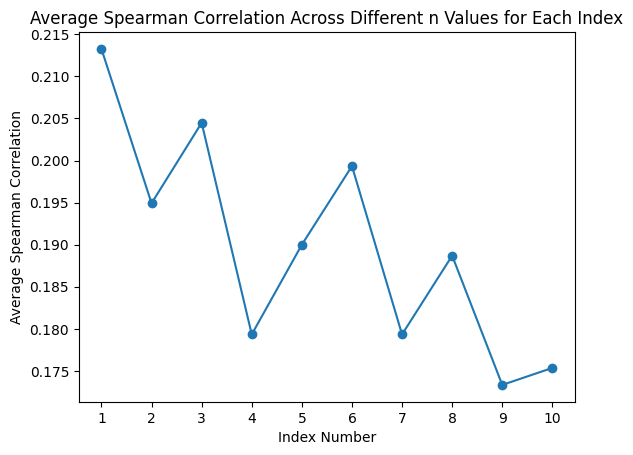

In [4]:
import matplotlib.pyplot as plt

# spearman_correlations_n5 = [0.2166, 0.1728, 0.1662, 0.2061, 0.2228, 0.1463, 0.2007, 0.1542, 0.2303, 0.1846]
# spearman_correlations_n10 = [0.2162, 0.2117, 0.2200, 0.1586, 0.1735, 0.1282, 0.1075, 0.1819, 0.1434, 0.1709]
# spearman_correlations_n15 = [0.2391, 0.2319, 0.1743, 0.1967, 0.2112, 0.2084, 0.1760, 0.1957, 0.1889, 0.1718]
# spearman_correlations_n20 = [0.2467, 0.2074, 0.1986, 0.2203, 0.1701, 0.1653, 0.1956, 0.1588, 0.1410, 0.1697]
# spearman_correlations_n25 = [0.2103, 0.2334, 0.2004, 0.1760, 0.2004, 0.2021, 0.1766, 0.2071, 0.1895, 0.1689]

spearman_correlations_n15_1 = [0.2172, 0.2012, 0.2333, 0.1664, 0.1905, 0.1974, 0.1576, 0.1808, 0.1821, 0.1847]
spearman_correlations_n15_2 = [0.2288, 0.1783, 0.2056, 0.1762, 0.1822, 0.2113, 0.1732, 0.1864, 0.1443, 0.1840]
spearman_correlations_n15_3 = [0.2342, 0.2060, 0.1944, 0.2179, 0.1619, 0.1601, 0.1990, 0.2112, 0.1740, 0.1859]
spearman_correlations_n15_4 = [0.1533, 0.1802, 0.2030, 0.1834, 0.2163, 0.2131, 0.1954, 0.1904, 0.1833, 0.1722]
spearman_correlations_n15_5 = [0.2328, 0.2089, 0.1861, 0.1528, 0.1991, 0.2148, 0.1715, 0.1747, 0.1830, 0.1500]

# Combine all lists into a single list of lists
# all_lists = [
#     spearman_correlations_n5,
#     spearman_correlations_n10,
#     spearman_correlations_n15,
#     spearman_correlations_n20,
#     spearman_correlations_n25,
# ]
all_lists = [
    spearman_correlations_n15_1,
    spearman_correlations_n15_2,
    spearman_correlations_n15_3,
    spearman_correlations_n15_4,
    spearman_correlations_n15_5,
]

# Calculate the average value for each index across all lists
index_averages = []
for i in range(len(spearman_correlations_n15_1)):  # Iterate through indices (0 to 9)
    index_values = [lst[i] for lst in all_lists]  # Get the value at index i from each list
    index_average = sum(index_values) / len(index_values)
    index_averages.append(index_average)

# Create a list of index numbers for the x-axis
index_numbers = list(range(1, len(spearman_correlations_n15_1) + 1))  # 1 to 10

# Plot the index averages in a line graph
plt.plot(index_numbers, index_averages, marker='o')

# Add labels and title
plt.xlabel("Index Number")
plt.ylabel("Average Spearman Correlation")
plt.title("Average Spearman Correlation Across Different n Values for Each Index")

# Customize the x-axis ticks
plt.xticks(index_numbers)

# Display the plot
plt.show()

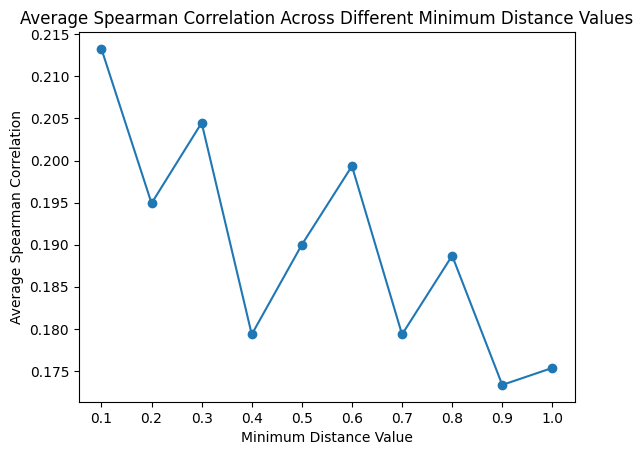

In [3]:
import matplotlib.pyplot as plt
import numpy as np

spearman_correlations_n15_1 = [0.2172, 0.2012, 0.2333, 0.1664, 0.1905, 0.1974, 0.1576, 0.1808, 0.1821, 0.1847]
spearman_correlations_n15_2 = [0.2288, 0.1783, 0.2056, 0.1762, 0.1822, 0.2113, 0.1732, 0.1864, 0.1443, 0.1840]
spearman_correlations_n15_3 = [0.2342, 0.2060, 0.1944, 0.2179, 0.1619, 0.1601, 0.1990, 0.2112, 0.1740, 0.1859]
spearman_correlations_n15_4 = [0.1533, 0.1802, 0.2030, 0.1834, 0.2163, 0.2131, 0.1954, 0.1904, 0.1833, 0.1722]
spearman_correlations_n15_5 = [0.2328, 0.2089, 0.1861, 0.1528, 0.1991, 0.2148, 0.1715, 0.1747, 0.1830, 0.1500]

all_lists = [
    spearman_correlations_n15_1,
    spearman_correlations_n15_2,
    spearman_correlations_n15_3,
    spearman_correlations_n15_4,
    spearman_correlations_n15_5,
]

# Calculate the average value for each index across all lists
index_averages = []
for i in range(len(spearman_correlations_n15_1)):
    index_values = [lst[i] for lst in all_lists]
    index_average = sum(index_values) / len(index_values)
    index_averages.append(index_average)

# Create a list of minimum distance values from 0.1 to 1.0 with intervals of 0.1
distance_values = np.arange(0.1, 1.1, 0.1)  # [0.1, 0.2, 0.3, ..., 0.9, 1.0]

# Plot the index averages in a line graph
plt.plot(distance_values, index_averages, marker='o')

# Add labels and title
plt.xlabel("Minimum Distance Value")
plt.ylabel("Average Spearman Correlation")
plt.title("Average Spearman Correlation Across Different Minimum Distance Values")

# Customize the x-axis ticks
plt.xticks(distance_values)

# Display the plot
plt.show()